### Question 4: Explainable AI (20 Marks)

##### a. Explain the methodologies and provide and in depth comparion of the methodologies.

##### b. Impements an explainable AI feature for the model you developed.

In [9]:
#install dependancies
!pip install shap

^C


In [ ]:
import torch
import torch.nn as nn
import os
import pandas as pd
import numpy as np
import joblib

import shap
shap.initjs()
print(shap.__version__)

##### Define the Model

In [11]:
# Define the model architecture.
class FullyConnectedNeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.network = nn.Sequential(

            #First Layer
            nn.Linear(input_size, 128),     # Input layer to 128 neurons
            nn.BatchNorm1d(128),
            nn.ReLU(),       # ReLU activation function
            nn.Dropout(p=0.2),

            # Second Layer
            nn.Linear(128, 64),    # 128 neurons to 64 neurons
            nn.BatchNorm1d(64),
            nn.ReLU(),       # Another ReLU
            nn.Dropout(p=0.2),

            # Third Layer
            nn.Linear(64, 32),    # 64 neurons to 32 neurons
            nn.BatchNorm1d(32),
            nn.ReLU(),       # Another ReLU
            nn.Dropout(p=0.2),

            # Fourth and the final Layer
            nn.Linear(32, 1),     # Output layer to 1 neurons (classes)
        )

    def forward(self, x):
        return self.network(x)

##### Load the model and the feature scalars

In [12]:
# load the model
def load_model(model_path, input_size):

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    model = FullyConnectedNeuralNetwork(input_size)
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    print("Model loaded successfully!")
    return model

In [13]:
# Get current directory
current_dir = os.path.abspath(".")

# model local file path
model_path = os.path.join(current_dir, 'model', 'optimized_model.pt')
loaded_model = load_model(model_path, input_size=41)

Model loaded successfully!


In [14]:
##### Load the X datasets
X_train_scaled = np.load(os.path.join(current_dir, 'model', 'X_train_scaled.npy'))
X_val_scaled = np.load(os.path.join(current_dir, 'model', 'X_val_scaled.npy'))
X_test_scaled = np.load(os.path.join(current_dir, 'model', 'X_test_scaled.npy'))


print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

(18000, 41)
(6000, 41)
(6000, 41)


In [16]:
# Background data
background_tensor = torch.tensor(X_test_scaled[:100], dtype=torch.float32)

# Create SHAP Explainer
explainer = shap.DeepExplainer(loaded_model, background_tensor)

# Explain test data
X_test_scaled_tensor = torch.tensor(X_test_scaled[:100], dtype=torch.float32)
shap_values = explainer(X_test_scaled_tensor)   # returns Explanation object

# shap_values is not a tensor, but an Explanation
print(type(shap_values))  
print(shap_values.shape)   # works like NumPy shape

<class 'shap._explanation.Explanation'>
(100, 41, 1)


In [17]:
feature_names = [
    "ExperienceYears", "Certifications", "PreviousCompanies", "Age", 
    "CompanySize", "CommuterSupport", "HealthInsurance", "FlexibleHours",
    "Gym", "Bonus", "StockOptions", "Retirement", "Gender_Female",
    "Gender_Male", "Gender_Non-binary", "RemoteOnsite_Hybrid",
    "RemoteOnsite_Onsite", "RemoteOnsite_Remote", "Industry_Consulting",
    "Industry_Finance", "Industry_Healthcare", "Industry_Retail",
    "Industry_Tech", "Education_Bachelors", "Education_Diploma",
    "Education_Masters", "Education_PhD", "Location_Australia",
    "Location_Germany", "Location_India", "Location_SriLanka",
    "Location_Sweden", "Location_UK", "Location_USA",
    "JobTitle_DataEngineer", "JobTitle_DataScientist",
    "JobTitle_FullstackDeveloper", "JobTitle_LeadEngineer",
    "JobTitle_SeniorSoftwareEngineer", "JobTitle_SoftwareArchitect",
    "JobTitle_SoftwareEngineer"
]

##### Global Explanation

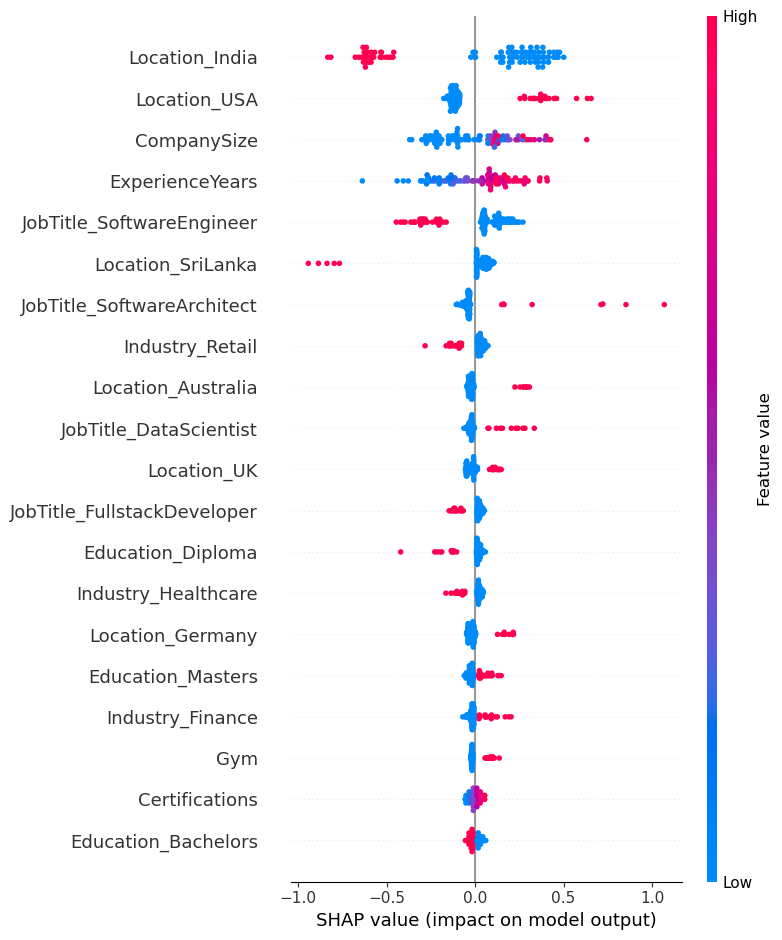

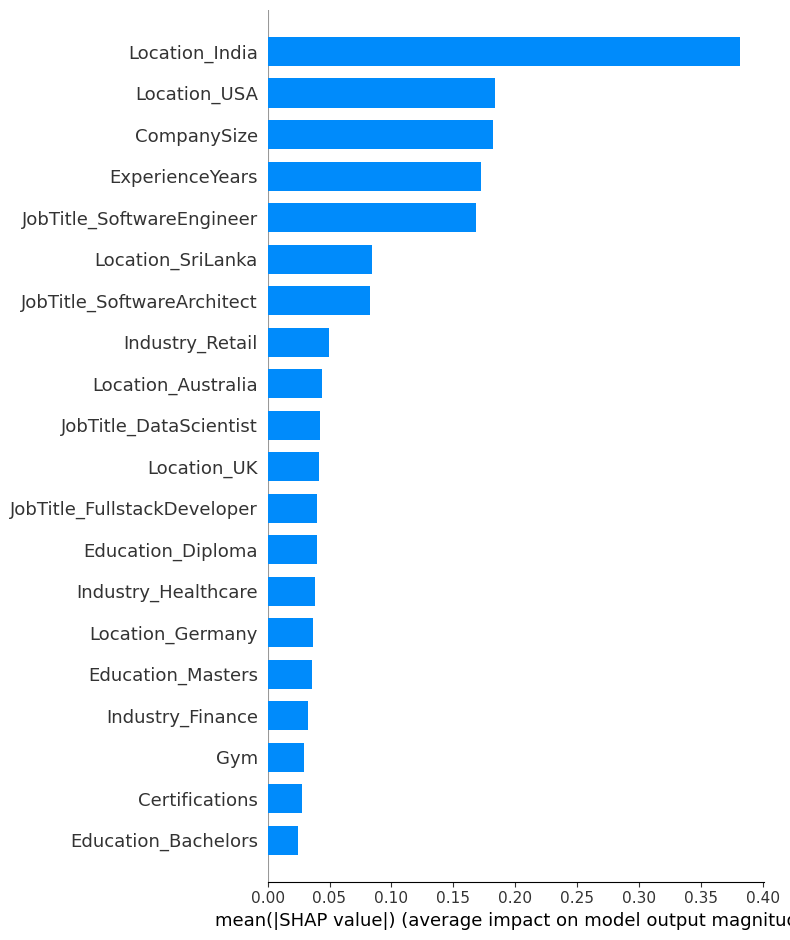

In [19]:
# Summary plot: shows feature importance and impact
shap.summary_plot(shap_values.values.squeeze(), X_test_scaled[:100], feature_names=feature_names)

# Bar plot: shows mean absolute SHAP value for each feature
shap.summary_plot(shap_values.values.squeeze(), X_test_scaled[:100], feature_names=feature_names, plot_type="bar")

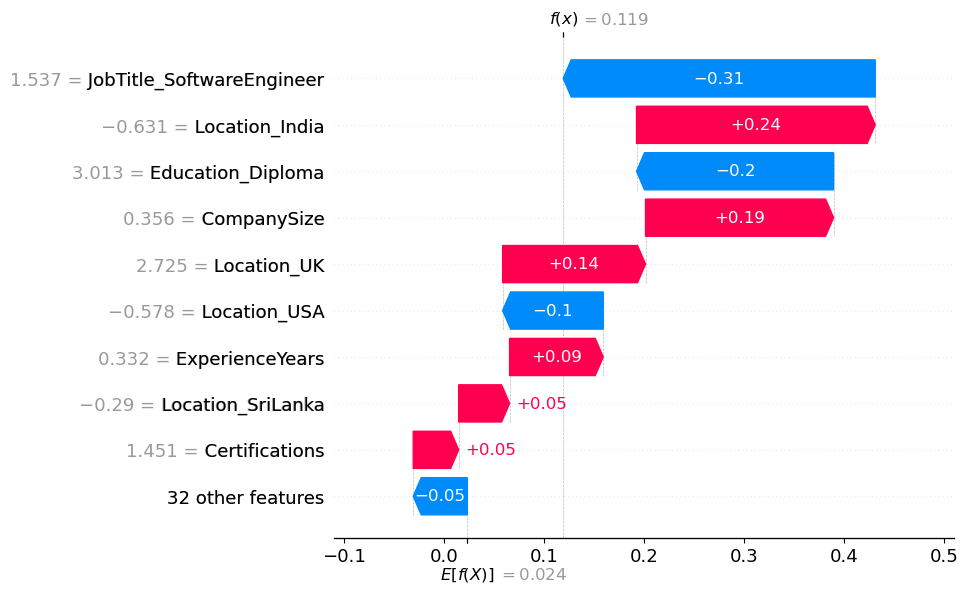

In [20]:
import shap

# For regression models, use shap_values directly
exp = shap.Explanation(
    values=shap_values.values[0].squeeze(),  # 1D array for one sample
    base_values=explainer.expected_value[0],  # scalar base value
    data=X_test_scaled[0],
    feature_names=feature_names
)

shap.plots.waterfall(exp)